### Discogs market analyzing tool
This project provides a comprehensive tool for analyzing trends in the music industry, allowing a deeper understanding of changes in music publishing over the years, taking into account different genres, countries and formats. Interactive elements allow users to explore the data on their own, making the project valuable for both researchers and those interested in music history.

### Technologies and libraries
The project uses popular Python libraries for data analysis and visualization:

	- pandas for data manipulation
	- matplotlib for creating graphs
	- numpy for numerical calculations
	- ipywidgets for creating interactive elements
	- scikit-learn for predictive analysis

### Authors
- Kacper Tyszkiewicz, 162949
- Mateusz Wiśniewski, 148327

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

In [2]:
FILENAME = "release_data_styles.csv"

# https://www.kaggle.com/datasets/sohrabdaemi/discogs-database-all-release-data?resource=download
# Download data from there, extract .zip and move release_data_styles.csv to project root

In [3]:
# Read file
df = pd.read_csv(FILENAME)
print(f"Rows in csv file: {len(df)}")

Rows in csv file: 31257071


In [4]:
df.head()

,release_id,country,year,genre,style,format
0,1,Sweden,1999.0,Electronic,Deep House,Vinyl
1,2,Sweden,1998.0,Electronic,Broken Beat,Vinyl
2,2,Sweden,1998.0,Electronic,Techno,Vinyl
3,2,Sweden,1998.0,Electronic,Tech House,Vinyl
4,3,US,1999.0,Electronic,Techno,CD


In [5]:
# Unique releases
unique_releases = df.drop_duplicates(subset=['release_id'])
unique_releases.head()

,release_id,country,year,genre,style,format
0,1,Sweden,1999.0,Electronic,Deep House,Vinyl
1,2,Sweden,1998.0,Electronic,Broken Beat,Vinyl
4,3,US,1999.0,Electronic,Techno,CD
6,4,US,1999.0,Electronic,House,CD
8,5,Germany,1995.0,Electronic,Abstract,CD


In [6]:
print(f"Unique releases: {len(unique_releases)}")

Unique releases: 12867980


In [20]:
print("Unique releases in 1980:", len(unique_releases[unique_releases["year"] == 1980]))
print("Unique releases in 2000:", len(unique_releases[unique_releases["year"] == 2000]))
print("Unique releases in 2020:", len(unique_releases[unique_releases["year"] == 2020]))
print("Unique releases in 2021:", len(unique_releases[unique_releases["year"] == 2021]))

# Remove newer releases due to the kaggle database being outdated (created in Nov 2020)
df = df[df["year"] < 2020]
unique_releases = unique_releases[unique_releases["year"] < 2020]

Unique releases in 1980: 137253
Unique releases in 2000: 224676
Unique releases in 2020: 124458
Unique releases in 2021: 0


### Discogs database growth over time

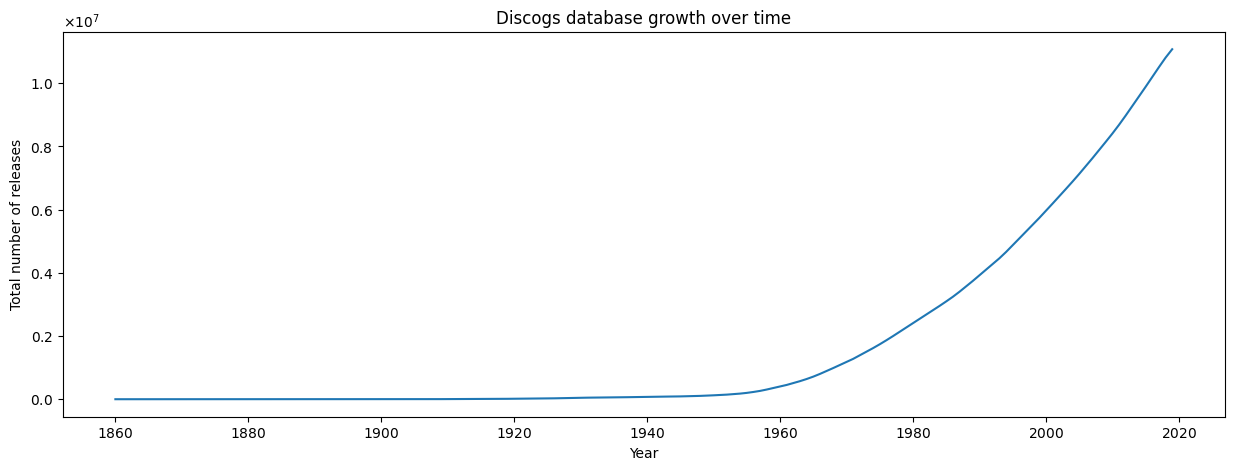

In [21]:
def plot_data_volume(df):
    data_volume = df.groupby('year').size().cumsum()
    plt.figure(figsize=(15, 5))
    plt.plot(data_volume.index, data_volume.values)
    plt.xlabel("Year")
    plt.ylabel("Total number of releases")
    plt.title("Discogs database growth over time")
    plt.ticklabel_format(useMathText=True)
    plt.show()

plot_data_volume(unique_releases)


### Discogs database growth rate over time

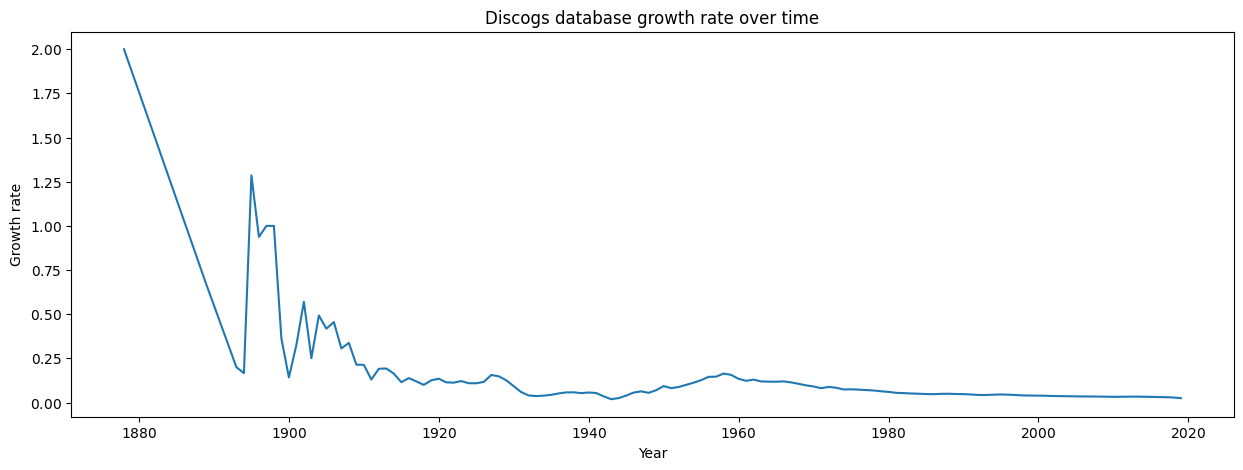

In [22]:
def plot_grow_rate_volume(df):
    data_volume = df.groupby('year').size().cumsum().pct_change()
    plt.figure(figsize=(15, 5))
    plt.plot(data_volume.index, data_volume.values)
    plt.xlabel("Year")
    plt.ylabel("Growth rate")
    plt.title("Discogs database growth rate over time")
    plt.ticklabel_format(useMathText=True)
    plt.show()

plot_grow_rate_volume(unique_releases)


### Plot releases by year from set genre/style, country and format

In [23]:
# Plot graph
def plot_graph(selected_style, selected_country, selected_format):
    plt.close("all")
    
    # Filter data
    data = filter_dataframe(df, "style", selected_style)
    data = filter_dataframe(data, "country", selected_country)
    data = filter_dataframe(data, "format", selected_format)
    data = data.groupby("year").size()
    data = data.reset_index(name="count")
    
    # Plot
    plt.clf()
    plt.figure(figsize=(15, 5))
    plt.plot(data["year"], data["count"])
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.title(f"Number of releases per year - {selected_style}")
    plt.show()
    
def filter_dataframe(df, header, option):
    return df if option == 'All' else df[df[header] == option]


In [24]:
# Dropdown values
style_options = ['All'] + df['style'].value_counts().index.tolist()
country_options = ['All'] + df['country'].value_counts().index.tolist()
format_options = ['All'] + df['format'].value_counts().index.tolist()

In [25]:
# Dropdown with plot
interactive_plot = widgets.interactive(plot_graph,
    # Style dropdown
    selected_style=widgets.Dropdown(
    options=style_options,
    description='Music style:',
    style={'description_width': 'initial'}),
    # Country dropdown
    selected_country=widgets.Dropdown(
    options=country_options,
    description='Country:',
    style={'description_width': 'initial'}),
    # Format dropdown
    selected_format=widgets.Dropdown(
    options=format_options,
    description='Format:',
    style={'description_width': 'initial'})
)
interactive_plot

interactive(children=(Dropdown(description='Music style:', options=('All', 'Pop Rock', 'Synth-pop', 'House', '…

#### Observations
- Pop Rock popularity has exploded in mid 1960s with The Beatles, The Rolling Stones and others making the gerne popular. It peaked in 1986~ and has since steadily fallen down.
- Synth Pop rapidly grew in 1980-1985 to then quickly fall back to a stable level.
- Death Metal popularity has steadily grown over all recorded years with a small dip shown in 2017~.
- Notable genres where one country dominates:
    - J-pop: Japan.
    - Jungle: UK.
    - Disco Polo: Poland
    - Favela Funk: Brazil
    - Eurodance: Europe (as a whole)

- Notable exceptions:
    - Italo-Disco: Italy only accounts for half of new releases during the genre peak.
    - Baltimore Club: US only accounts for half~ of releases.


### Polynomial regression - prediction of vinyl releases based on history

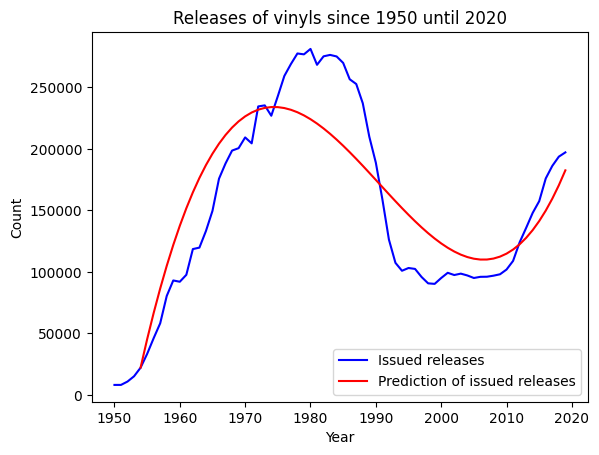

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

data = df[df["year"] >= 1950]
data = data[data["year"] < 2020]

data = data[data["format"] == "Vinyl"]
data = data.groupby("year").size()
data = data.reset_index(name="count")

X = data["year"]
Y = data["count"]

poly = PolynomialFeatures(degree=4)
poly_features = poly.fit_transform(X.values.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, Y)
y_predicted = poly_reg_model.predict(poly_features)

plt.plot(X, Y, c="b", label="Issued releases")
plt.plot(X[y_predicted > 0], y_predicted[y_predicted > 0], c="red", label="Prediction of issued releases")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Releases of vinyls since 1950 until 2020")
plt.show()